In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Shape estimation of Galaxies in EAGLE simulations

- Author: Quentin Petit
- Date: 2023-05-14

### /!\ Caution - This code works for small catalogues. For larger catalogues you need a lot of RAM. It is better to run this kind of code on dedicated compute servers. 

This notebook will guide you through the process of estimating the shape of galaxies in EAGLE simulations. The EAGLE simulations are a suite of cosmological hydrodynamical simulations that aim to study the formation and evolution of galaxies in a representative volume of the universe.

The shape estimation of galaxies is an important task in understanding their morphology and mass distribution. It provides insights into the formation mechanisms, alignment, and orientation of galaxies. In this notebook, we will utilize the MOGPy package, which is specifically designed for the analysis of galaxy morphology in both 2D and 3D.

To get started, make sure you have a snapshot of the simulation in FITS format. If you don't have one, don't worry! We have provided a convenient tutorial to download and process data in `download_and_visualise_EAGLE_data.ipynb`.

The main steps covered in this notebook include:

1. Opening and loading the EAGLE simulation snapshot.
2. Estimating the shape, orientation, and mass distribution of galaxies using the MOGPy package.
3. Visualizing and analyzing the results.

In [2]:
# Import necessary packages
import sys
sys.path.append(r"../MOGPy/")

import utils.functions as f0
import utils.eagle_functions as eagle_f0

import os
import h5py
import numpy as np
import eagleSqlTools as sql
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse

font = {'family' : 'serif', 'size' : '20'}
plt.rc('font', **font)
px = 1/plt.rcParams['figure.dpi']

### Opening and loading the EAGLE simulation snapshot

To begin, we need to open and load the EAGLE simulation snapshot data. The snapshot file is located at `../data/catalogues_fits/{Catalogue_Ref}/{Snapshot_name}/EAGLE_{Catalogue_Ref}_Snapshot{Snapshot_number}_MassMIN{MinMass}_MassMAX{MaxMass}.fits`. We will use the `Table.read` function from the `astropy.table` module to read the FITS file into a table object.

Here is the code to open and load the snapshot data:

In [3]:
# Catalogue references
# List all snapshots and redshifts of the EAGLE simulation
A = [f'0{n}' for n in range(10)]
Abis = [f'{n+10}' for n in range(28-9)]
A.extend(Abis)
z = ['020','015','009','008','008','007','005','005','005','004','003','003','003','002','002','002','001','001','001','001','000','000','000','000','000','000','000','000','000']
p = ['000','132','993','988','075','050','971','487','037','485','984','528','017','478','237','012','737','487','259','004','865','736','615','503','366','271','183','101','000']
B = [f'snapshot_0{A}_z{z}p{p}' for A,z,p in zip(A,z,p)]
C = [f'snap_0{A}_z{z}p{p}' for A,z,p in zip(A,z,p)]

In [4]:
# Choose catalogue
Catalogue_Ref = 'RefL0025N0376'

# Choose mass range
MinMass = 5
MaxMass = 13

# Choose Snapshot N
N = 23

In [5]:
Snapshot_number = A[N]
Snapshot_name   = B[N]
Snapshot_file   = C[N]

# Path to the snapshot FITS file
snapshot_file = f'../data/catalogues_fits/{Catalogue_Ref}/{Snapshot_name}/EAGLE_{Catalogue_Ref}_Snapshot{Snapshot_number}_MassMIN{MinMass}_MassMAX{MaxMass}.fits'

# Read the snapshot data into a table
hdu = Table.read(snapshot_file, format='fits')

# Convert the table to a pandas DataFrame
data = hdu.to_pandas()

# Display the available keys/columns in the data
data.keys()

Index(['GroupNumber', 'SubGroupNumber', 'itype', 'Mass', 'Coordinates_x',
       'Coordinates_y', 'Coordinates_z', 'Velocity_x', 'Velocity_y',
       'Velocity_z'],
      dtype='object')

### Shape analysis

You will find in `main.py` the functions that allow you to carry out the whole study in a single command. For this tutorial I will detail the steps one by one.

First, you must choose the type of particle you wish to study by declaring the variable *itype*:

- Gas particles: *itype = 0*
- Dark matter particles: *itype = 1*
- Stars particles: *itype = 4*
- Black holes particles: *itype = 5*
- All particles: *itype = 10* (personal choice)

Secondly, it is advisable to set a limit on the minimum number of particles for the halo to be considered. Otherwise, the code that calculates densities may not work. A minimum of 100 particles is a good choice.

Finally, choose the number of the halo (galaxy) you wish to study. In the EAGLE simulations, this variable is called *GroupNumber*.

You can also choose whether or not to consider sub-halos by setting *SubHalo = 0 or 1*. 

In [6]:
itype = 1
minimum_particles = 100
GroupNumber = 25
SubHalo = 1

The code below calls the particles according to the previous variables. The coordinates are stored in a single *coordinate* variable of dimension (3, N) and the mass of the particles in the *masses* variable of dimension (N). *N* is the number of particles in the halo.

In [7]:
if itype ==10:
    all_particles = 1
else:
    all_particles = 0
if all_particles == 1:
    if SubHalo == 0:
        coordinates = np.array([hdu['Coordinates_x'][(hdu['GroupNumber']==GroupNumber)&(hdu['SubGroupNumber']==SubHalo)],
                                hdu['Coordinates_y'][(hdu['GroupNumber']==GroupNumber)&(hdu['SubGroupNumber']==SubHalo)],
                                hdu['Coordinates_z'][(hdu['GroupNumber']==GroupNumber)&(hdu['SubGroupNumber']==SubHalo)]])
        masses = np.array([hdu['Mass'][(hdu['GroupNumber']==GroupNumber)&(hdu['SubGroupNumber']==SubHalo)]])
    else:
        coordinates = np.array([hdu['Coordinates_x'][(hdu['GroupNumber']==GroupNumber)],
                                hdu['Coordinates_y'][(hdu['GroupNumber']==GroupNumber)],
                                hdu['Coordinates_z'][(hdu['GroupNumber']==GroupNumber)]])
        masses = np.array([hdu['Mass'][(hdu['GroupNumber']==GroupNumber)]])
else:
    if SubHalo == 0:
        coordinates = np.array([hdu['Coordinates_x'][(hdu['GroupNumber']==GroupNumber)&(hdu['SubGroupNumber']==SubHalo)&(hdu['itype']==itype)],
                                hdu['Coordinates_y'][(hdu['GroupNumber']==GroupNumber)&(hdu['SubGroupNumber']==SubHalo)&(hdu['itype']==itype)],
                                hdu['Coordinates_z'][(hdu['GroupNumber']==GroupNumber)&(hdu['SubGroupNumber']==SubHalo)&(hdu['itype']==itype)]])
        masses = np.array([hdu['Mass'][(hdu['GroupNumber']==GroupNumber)&(hdu['SubGroupNumber']==SubHalo)&(hdu['itype']==itype)]])
    else:
        coordinates = np.array([hdu['Coordinates_x'][(hdu['GroupNumber']==GroupNumber)&(hdu['itype']==itype)],
                                hdu['Coordinates_y'][(hdu['GroupNumber']==GroupNumber)&(hdu['itype']==itype)],
                                hdu['Coordinates_z'][(hdu['GroupNumber']==GroupNumber)&(hdu['itype']==itype)]])
        masses = np.array(hdu['Mass'][(hdu['GroupNumber']==GroupNumber)&(hdu['itype']==itype)])

# Check if the halo have enough particles to continue
if len(masses) > minimum_particles:
    print('Number of particles =', len(masses))
else:
    print('Not enough particles in the halo',GroupNumber,'with SubHalo =', SubHalo)

Number of particles = 173583


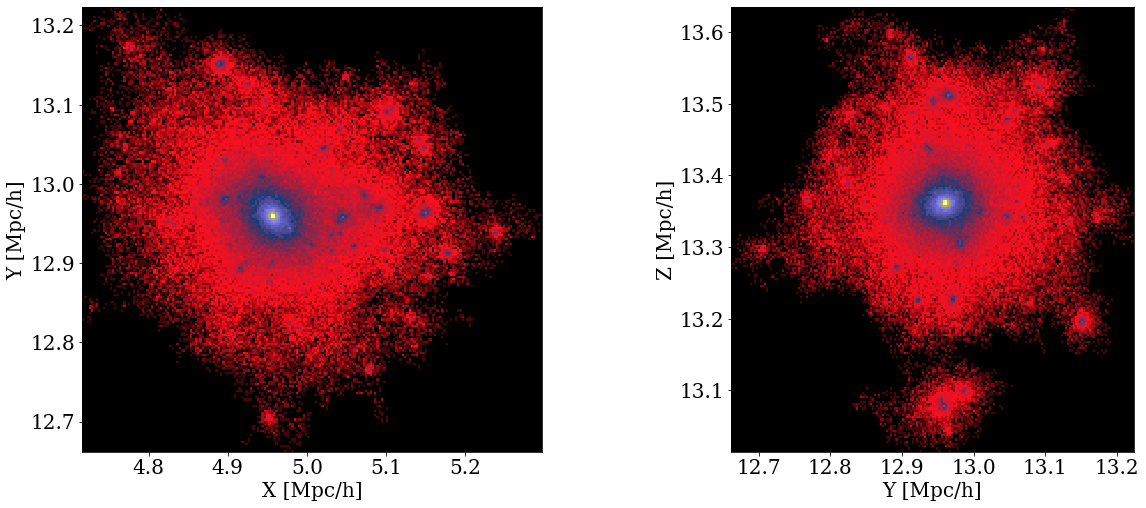

In [8]:
fig = plt.figure(figsize=(2.5*500*px,500*px),constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])

ax1.hist2d(coordinates[0],coordinates[1],bins=(200,200),density=True,norm=mcolors.PowerNorm(0.6),cmap=plt.cm.gist_stern)
ax2.hist2d(coordinates[1],coordinates[2],bins=(200,200),density=True,norm=mcolors.PowerNorm(0.6),cmap=plt.cm.gist_stern)

ax1.set_aspect(1) 
ax2.set_aspect(1) 

ax1.set_xlabel('X [Mpc/h]')
ax1.set_ylabel('Y [Mpc/h]')
ax2.set_xlabel('Y [Mpc/h]')
ax2.set_ylabel('Z [Mpc/h]')

plt.show()

Since universe simulations are made in cubes, it must be taken into account that a halo on one of the edges of the cube will see its coordinates loop on the other side of the cube. 

To "re-stick" the coordinates of these galaxies here is a little code:

In [9]:
# Find where halos are on the cube edges
box_max = np.max(np.array([np.max(hdu['Coordinates_x']),np.max(hdu['Coordinates_y']),np.max(hdu['Coordinates_z'])]))
coordinates = f0.solving_the_box_problem(coordinates, box_max)

## 1. Set origin

Sets the origin of the coordinate system based on the median of a 3D distribution of points.If the *CentreOfMass* is provided, it will be used as the initial median estimate.

In [10]:
coordinates_new, median_list = f0.set_origin(coordinates, CentreOfMass=None)

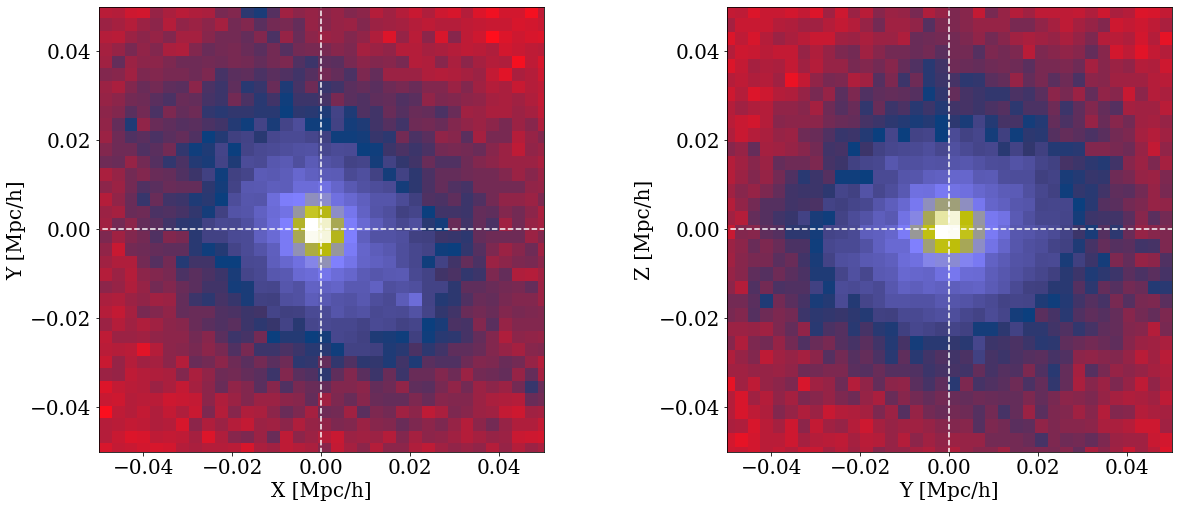

In [11]:
fig = plt.figure(figsize=(2.5*500*px,500*px),constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])

ax1.hist2d(coordinates_new[0],coordinates_new[1],bins=(200,200),density=True,norm=mcolors.PowerNorm(0.6),cmap=plt.cm.gist_stern)
ax2.hist2d(coordinates_new[1],coordinates_new[2],bins=(200,200),density=True,norm=mcolors.PowerNorm(0.6),cmap=plt.cm.gist_stern)

ax1.plot(np.linspace(-1,1,2), np.linspace(0,0,2), '--', color='white')
ax1.plot(np.linspace(0,0,2), np.linspace(-1,1,2), '--', color='white')
ax2.plot(np.linspace(-1,1,2), np.linspace(0,0,2), '--', color='white')
ax2.plot(np.linspace(0,0,2), np.linspace(-1,1,2), '--', color='white')

ax1.set_aspect(1) 
ax2.set_aspect(1) 

ax1.set_xlabel('X [Mpc/h]')
ax1.set_ylabel('Y [Mpc/h]')
ax2.set_xlabel('Y [Mpc/h]')
ax2.set_ylabel('Z [Mpc/h]')

ax1.set_xlim(-0.05,0.05)
ax1.set_ylim(-0.05,0.05)
ax2.set_xlim(-0.05,0.05)
ax2.set_ylim(-0.05,0.05)

plt.show()

## 2. Working sphere

In order to confidently measure the shape properties of a halo, we need to get rid of the influence of peripheral sub-structures. For this, we aim to determine a working spherical volume characterised by its radius, $r_{80cc}$, that encompasses a sufficient amount of mass while not including the perturbing sub-structures. $r_{80cc}$ is empirically chosen as the radius at which the density drops by 80% from the central core density. The computed sphere then delimits the volume comprising the particles we chose to consider.

In the code, $r_{80cc}$ is called *density_radius*.

Two new parameters are needed here:
   - density_core: The desired density in the core region, ranging from 0 to 1.
   - fraction_density: The desired fraction of the maximum density, ranging from 0 to 1. For $r_{80cc}$ it will be 0.2.
   
#### /!\ If there is a problem in the calculation of *density_radius*, the function returns a radius of 30 kpc by default.

In [12]:
# New parameters
density_core = 0.9
fraction_density = 0.2

# Call the function
density_radius = f0.find_density_radius(coordinates, density_core, fraction_density, masses, GroupNumber)

print('Density radius =', density_radius)

Density radius = 0.06


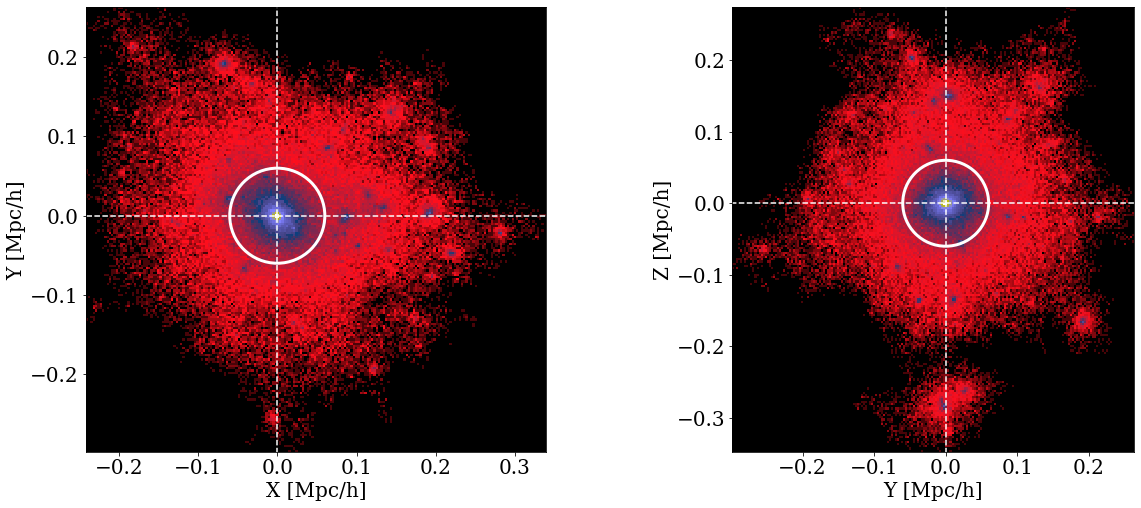

In [13]:
fig = plt.figure(figsize=(2.5*500*px,500*px),constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])

ax1.hist2d(coordinates_new[0],coordinates_new[1],bins=(200,200),density=True,norm=mcolors.PowerNorm(0.6),cmap=plt.cm.gist_stern)
ax2.hist2d(coordinates_new[1],coordinates_new[2],bins=(200,200),density=True,norm=mcolors.PowerNorm(0.6),cmap=plt.cm.gist_stern)

cc = plt.Circle((0,0), density_radius, edgecolor='white', facecolor='none', linewidth=3)
ax1.set_aspect(1) 
ax1.add_artist(cc)
cc = plt.Circle((0,0), density_radius, edgecolor='white', facecolor='none', linewidth=3)
ax2.set_aspect(1) 
ax2.add_artist(cc)

ax1.plot(np.linspace(-1,1,2), np.linspace(0,0,2), '--', color='white')
ax1.plot(np.linspace(0,0,2), np.linspace(-1,1,2), '--', color='white')
ax2.plot(np.linspace(-1,1,2), np.linspace(0,0,2), '--', color='white')
ax2.plot(np.linspace(0,0,2), np.linspace(-1,1,2), '--', color='white')

ax1.set_xlabel('X [Mpc/h]')
ax1.set_ylabel('Y [Mpc/h]')
ax2.set_xlabel('Y [Mpc/h]')
ax2.set_ylabel('Z [Mpc/h]')

plt.show()

# 3D shape analysis

Now that the data have been prepared it is possible to extract the morphological characteristics of the halos.

For this we need 3 steps:
1. Selects particles within a density radius from the center and applies a Principal Component Analysis (PCA) to find the main axes in a three-dimensional space.
2. Align coordinates on main axes
3. PCA is re-applied iteratively to the selection of particles encompassed in the ellipsoid defined by the semi-axes derived at previous iteration

In [14]:
# Number of iterations
ite = 10

# 1.
core_rotation_matrix, core_a, core_b, core_c = f0.select_core_and_apply_method(coordinates_new, density_radius, _2D=False)

# 2.
align_coordinates = f0.to_align_coordinates(coordinates_new, core_rotation_matrix)

# 3.
axis_a, axis_b, axis_c = f0.ite_for_axis_ratios_3D(align_coordinates, core_a, core_b, core_c, ite, GroupNumber, density_radius)

In [15]:
print('Axis ratio b/a = {:.2f}'.format(axis_b/axis_a))
print('Axis ratio c/a = {:.2f}'.format(axis_c/axis_a))

Axis ratio b/a = 0.82
Axis ratio c/a = 0.78
